In [1]:
%load_ext autoreload
%autoreload 2

# Training

In this notebook we show how to train a model to automatically extract roads from the Sentinel-2 imagery using the [MassachussettsRoadsS2](https://www.eotdl.com/datasets/MassachusettsRoadsS2) dataset.

In [2]:
!eotdl version

EOTDL Version: 2025.06.27-2


# Dataset

First, we stage the model from the EOTDL or use the one generated in the `dataset.ipynb` notebook.

In [7]:
# !eotdl datasets get MassachusettsRoadsS2 -p data -a -f

Visualize samples

In [8]:
from eotdl.pytorch.segmentation import SegmentationDataModule
import albumentations as A

# dm = DataModule('data/MassachusettsRoadsS2')

trans = A.Compose([
    A.CenterCrop(width=128, height=128),
], is_check_shapes=False)

dm = SegmentationDataModule(
    'data/MassachusettsRoadsS2/tiff', 
    train_source_path='train_s2', 
    val_source_path='val_s2', 
    train_labels_path='train_s2_labels', 
    val_labels_path='val_s2_labels', 
    test_source_path='test_s2', 
    test_labels_path='test_s2_labels', 
    train_trans=trans, 
    val_trans=trans, 
    test_trans=trans,
    source_ext='.tiff',
    label_ext='.tif'
)

dm.setup()

In [9]:
batch = next(iter(dm.train_dataloader()))

images, masks = batch

images.shape, masks.shape

(torch.Size([5, 3, 128, 128]), torch.Size([5, 1, 128, 128]))

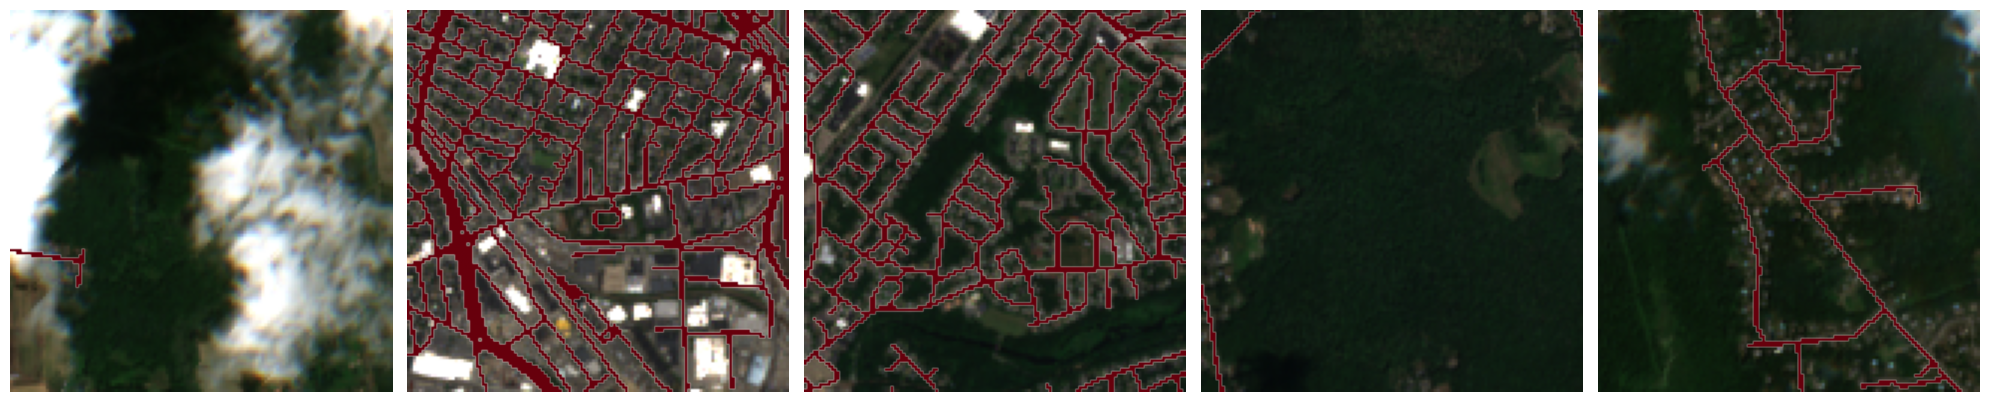

In [10]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 5, figsize=(20, 8))
batch = next(iter(dm.train_dataloader()))
for i, idx in enumerate(range(5)):
    image, mask = batch[0][idx], batch[1][idx][0]
    axes[i].imshow(np.transpose(image, (1, 2, 0)))
    axes[i].imshow(mask, alpha=mask, cmap='Reds', vmin=0, vmax=1)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Model

In [11]:
from eotdl.pytorch.segmentation import SegmentationModule

module = SegmentationModule(num_classes=1)

module

SegmentationModule(
  (model): SegmentationModel(
    (encoder): FeatureListNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act1): ReLU(inplace=True)
          (aa): Identity()
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act2): ReLU(inplace=True)
        )
        (1): BasicBloc

In [12]:
ouptuts = module(images)

ouptuts.shape

torch.Size([5, 1, 128, 128])

# Training

We can validate the implementation by overfitting the model on a single batch.

In [16]:
import lightning as L

trans = A.Compose([
    A.CenterCrop(width=128, height=128),
], is_check_shapes=False)

dm = SegmentationDataModule(
    'data/MassachusettsRoadsS2/tiff', 
    train_source_path='train_s2', 
    val_source_path='val_s2', 
    train_labels_path='train_s2_labels', 
    val_labels_path='val_s2_labels', 
    test_source_path='test_s2', 
    test_labels_path='test_s2_labels', 
    train_trans=trans, 
    val_trans=trans, 
    test_trans=trans,
    source_ext='.tiff',
    label_ext='.tif',
    batch_size=4,
    num_workers=4,
    pin_memory=True
)

module = SegmentationModule(num_classes=1)

trainer = L.Trainer(
    max_epochs=10,
    accelerator='gpu',
    devices=1,
    overfit_batches=1,
    enable_checkpointing=False,
    logger=None
)

trainer.fit(module, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
`Trainer(overfit_batches=1)` was configured so 1 batch will be used.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type              | Params | Mode 
----------------------------------------------------
0 | model | SegmentationModel | 14.3 M | train
1 | loss  | BCEWithLogitsLoss | 0      | train
----------------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.378    Total estimated model params size (MB)
144       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


The full training is performed in the [training.py](training.py) script. We can check the logs.

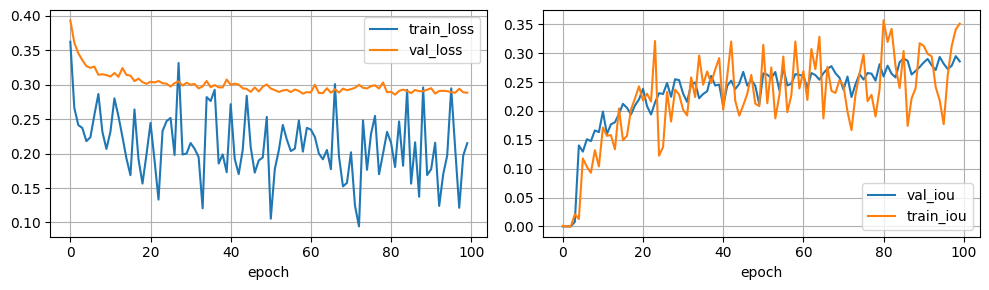

In [20]:
import pandas as pd
import os
import matplotlib.pyplot as plt

versions = sorted(os.listdir('logs/gdaapp'))
last_version = versions[-1]

metrics = pd.read_csv(f'logs/gdaapp/{last_version}/metrics.csv')
metrics = metrics.groupby('epoch').last().reset_index()

fig, axs = plt.subplots(1, 2, figsize=(10, 3))
metrics.plot(x='epoch', y='train_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_loss', kind='line', ax=axs[0], grid=True)
metrics.plot(x='epoch', y='val_iou', kind='line', ax=axs[1], grid=True)
metrics.plot(x='epoch', y='train_iou', kind='line', ax=axs[1], grid=True)
plt.tight_layout()
plt.show()


Visualize model predictions

In [21]:
checkpoints = os.listdir('checkpoints')
checkpoints

['last.ckpt', 'epoch=98-val_iou=0.2950.ckpt']

In [40]:
from eotdl.pytorch.segmentation import SegmentationDataModule, SegmentationModule
import albumentations as A

trans = A.Compose([
    A.CenterCrop(width=128, height=128),
], is_check_shapes=False)

dm = SegmentationDataModule(
    'data/MassachusettsRoadsS2/tiff', 
    train_source_path='train_s2', 
    val_source_path='val_s2', 
    train_labels_path='train_s2_labels', 
    val_labels_path='val_s2_labels', 
    test_source_path='test_s2', 
    test_labels_path='test_s2_labels', 
    train_trans=trans, 
    val_trans=trans, 
    test_trans=trans,
    source_ext='.tiff',
    label_ext='.tif',
    batch_size=5,
    num_workers=0,
    pin_memory=False
)


dm.setup()

module = SegmentationModule.load_from_checkpoint(f'checkpoints/epoch=98-val_iou=0.2950.ckpt')

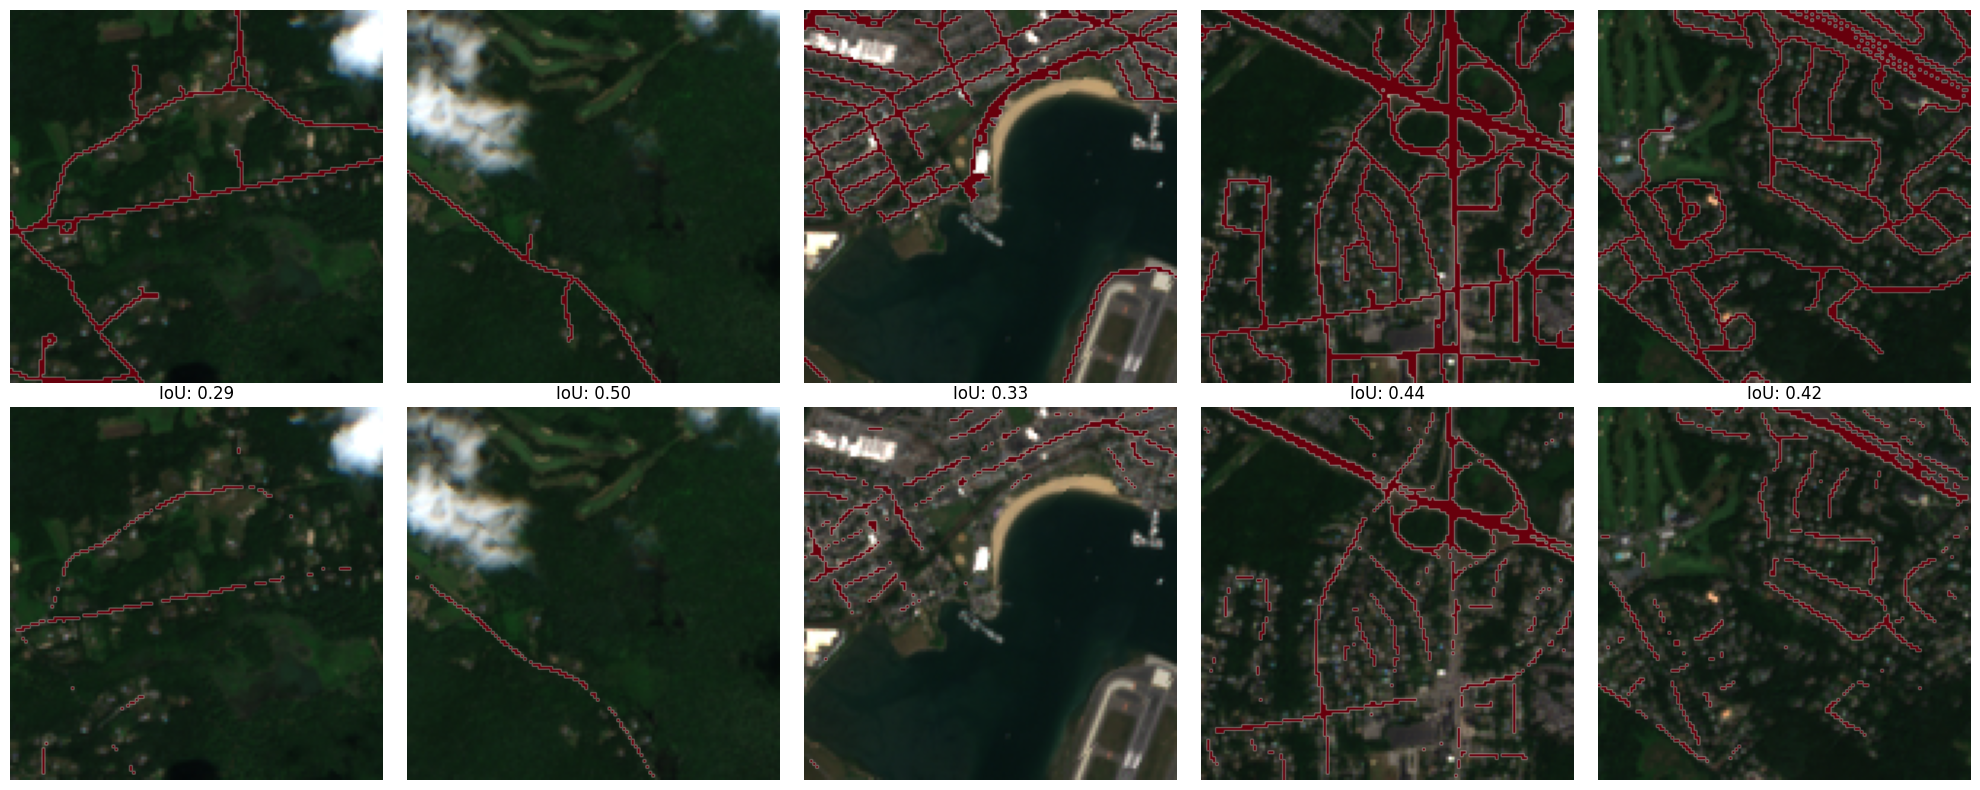

In [65]:
from eotdl.pytorch.segmentation.metrics import iou
import numpy as np
import torch

batch = next(iter(dm.test_dataloader(shuffle=True)))
images, masks = batch

with torch.no_grad():
    preds = module(images.to(module.device)).cpu()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(range(5)):
    image, mask = images[idx], masks[idx][0]
    pred = preds[idx][0]
    axes[1, i].set_title(f'IoU: {iou(pred, mask):.2f}')
    pred = pred > 0.5
    pred = pred.float()
    axes[0, i].imshow(np.transpose(image, (1, 2, 0)))
    axes[0, i].imshow(mask, alpha=mask, cmap='Reds', vmin=0, vmax=1)
    # axes[i].imshow(pred, alpha=pred, cmap='Reds', vmin=0, vmax=1)
    axes[0, i].axis('off')
    axes[1, i].imshow(np.transpose(image, (1, 2, 0)))
    axes[1, i].imshow(pred, alpha=pred, cmap='Reds', vmin=0, vmax=1)
    axes[1, i].axis('off')
plt.tight_layout()

# Export model

We export the model to ONNX format.

In [66]:
import torch

export_model = torch.nn.Sequential(
    module,
    torch.nn.Sigmoid()
)
export_model.eval()
export_model.to('cpu');

In [67]:
torch.onnx.export(
	export_model,
	images,
	'outputs/model.onnx',
	export_params=True,
	input_names=['input'],
	output_names=['output'],
	dynamic_axes={
		'input': {
			0: 'batch_size',
			2: 'height',
			3: 'width'
		}, 
		'output': {
			0: 'batch_size'
		}
	}
)

In [68]:
import onnxruntime
import numpy as np

ort_session = onnxruntime.InferenceSession('outputs/model.onnx')
input_name = ort_session.get_inputs()[0].name
ort_inputs = {input_name: images.numpy()}
ort_outs = ort_session.run(None, ort_inputs)
ort_outs[0].shape

(5, 1, 128, 128)

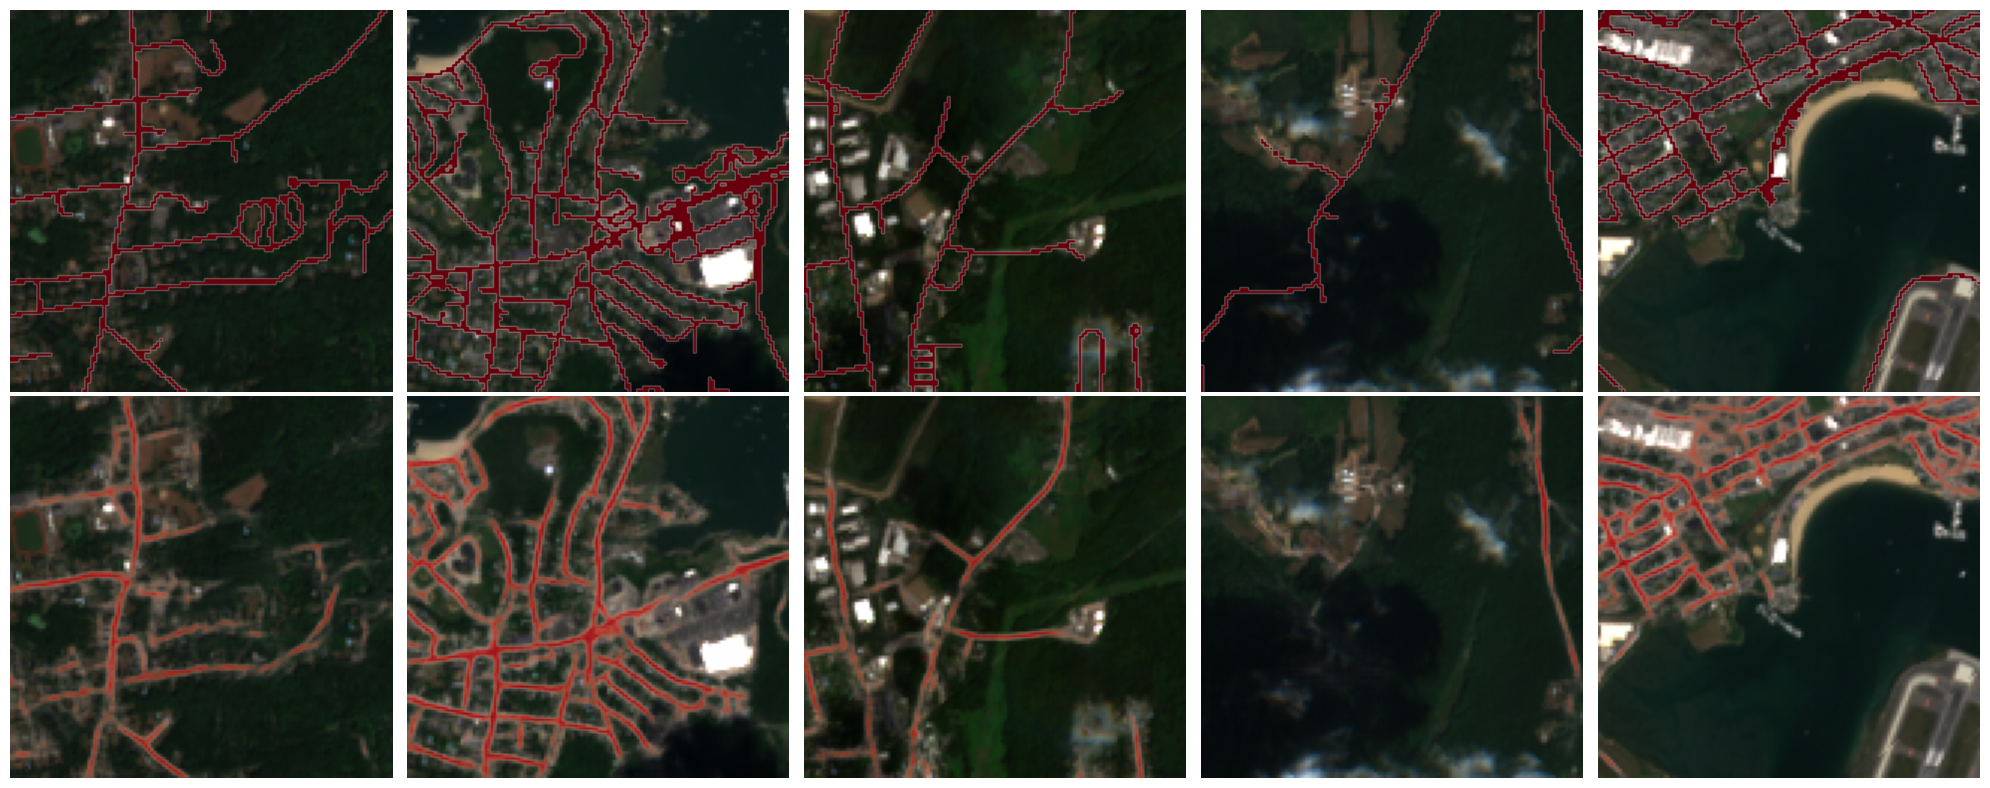

In [69]:
batch = next(iter(dm.test_dataloader(shuffle=True)))
images, masks = batch

ort_inputs = {input_name: images.numpy()}
preds = ort_session.run(None, ort_inputs)[0]

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
for i, idx in enumerate(range(5)):
    image, mask = images[idx], masks[idx][0]
    pred = preds[idx][0]
    axes[0, i].imshow(np.transpose(image, (1, 2, 0)))
    axes[0, i].imshow(mask, alpha=mask, cmap='Reds', vmin=0, vmax=1)
    # axes[i].imshow(pred, alpha=pred, cmap='Reds', vmin=0, vmax=1)
    axes[0, i].axis('off')
    axes[1, i].imshow(np.transpose(image, (1, 2, 0)))
    axes[1, i].imshow(pred, alpha=pred, cmap='Reds', vmin=0, vmax=1)
    axes[1, i].axis('off')
plt.tight_layout()

You can now ingest the model into the EOTDL or use the one already provided at https://www.eotdl.com/models/MassachusettsRoadsS2Model